In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression, PLSSVD
import time
import itertools

In [2]:
# Import data and clean
df = pd.read_excel('Lending Club.xlsx')
df = df.dropna()
dummies = pd.get_dummies(df[['Home', 'emp_length']])

y = df['Loan_rate']

# Drop the column with the independent variable (Loan_rate), and columns for which we created dummy variables
X_ = df.drop(['Loan_rate', 'Home', 'emp_length'], axis=1).astype('float64')

# Define the feature set X. Reference group for emp_length is <1 year. Reference group for Home is 'own'.
X = pd.concat([X_, dummies[['emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'Home_MORTGAGE', 'Home_RENT']]], axis=1).astype(float)

X.columns

Index(['Loan_amt', 'Loan_term', 'Income_source_verified', 'Income_verified',
       'Income_thou', 'Debt_income', 'delinq_2yrs', 'Credit_history_length',
       'FICO', 'open_acc', 'Derogatory_recs', 'Revol_balance', 'Revol_util',
       'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'Home_MORTGAGE', 'Home_RENT'],
      dtype='object')

In [3]:
# Split into training and test sets
X_train, X_test , y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=1)

### Best subset Selection

In [4]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [5]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [6]:
# # Kernel crashed likely due to an excessive number of features and overflow

# models_best = pd.DataFrame(columns=["RSS", "model"])

# tic = time.time()
# for i in range(1,8):
# # for i in range(1,4):
#     models_best.loc[i] = getBest(i)

# toc = time.time()
# print("Total elapsed time:", (toc-tic), "seconds.")

##### Because of the large number of variables, best subset selection takes more than 30 minutes to run and often result in crash.

### Forward Selection

In [7]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [8]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  25 models on 1 predictors in 0.1470019817352295 seconds.
Processed  24 models on 2 predictors in 0.1414632797241211 seconds.
Processed  23 models on 3 predictors in 0.2441716194152832 seconds.
Processed  22 models on 4 predictors in 0.1919090747833252 seconds.
Processed  21 models on 5 predictors in 0.30460119247436523 seconds.
Processed  20 models on 6 predictors in 0.33931994438171387 seconds.
Processed  19 models on 7 predictors in 0.3030097484588623 seconds.
Processed  18 models on 8 predictors in 0.3092331886291504 seconds.
Processed  17 models on 9 predictors in 0.37593531608581543 seconds.
Processed  16 models on 10 predictors in 0.4832484722137451 seconds.
Processed  15 models on 11 predictors in 0.48092150688171387 seconds.
Processed  14 models on 12 predictors in 0.4204282760620117 seconds.
Processed  13 models on 13 predictors in 0.4169504642486572 seconds.
Processed  12 models on 14 predictors in 0.41068434715270996 seconds.
Processed  11 models on 15 predictors 

Text(0, 0.5, 'BIC')

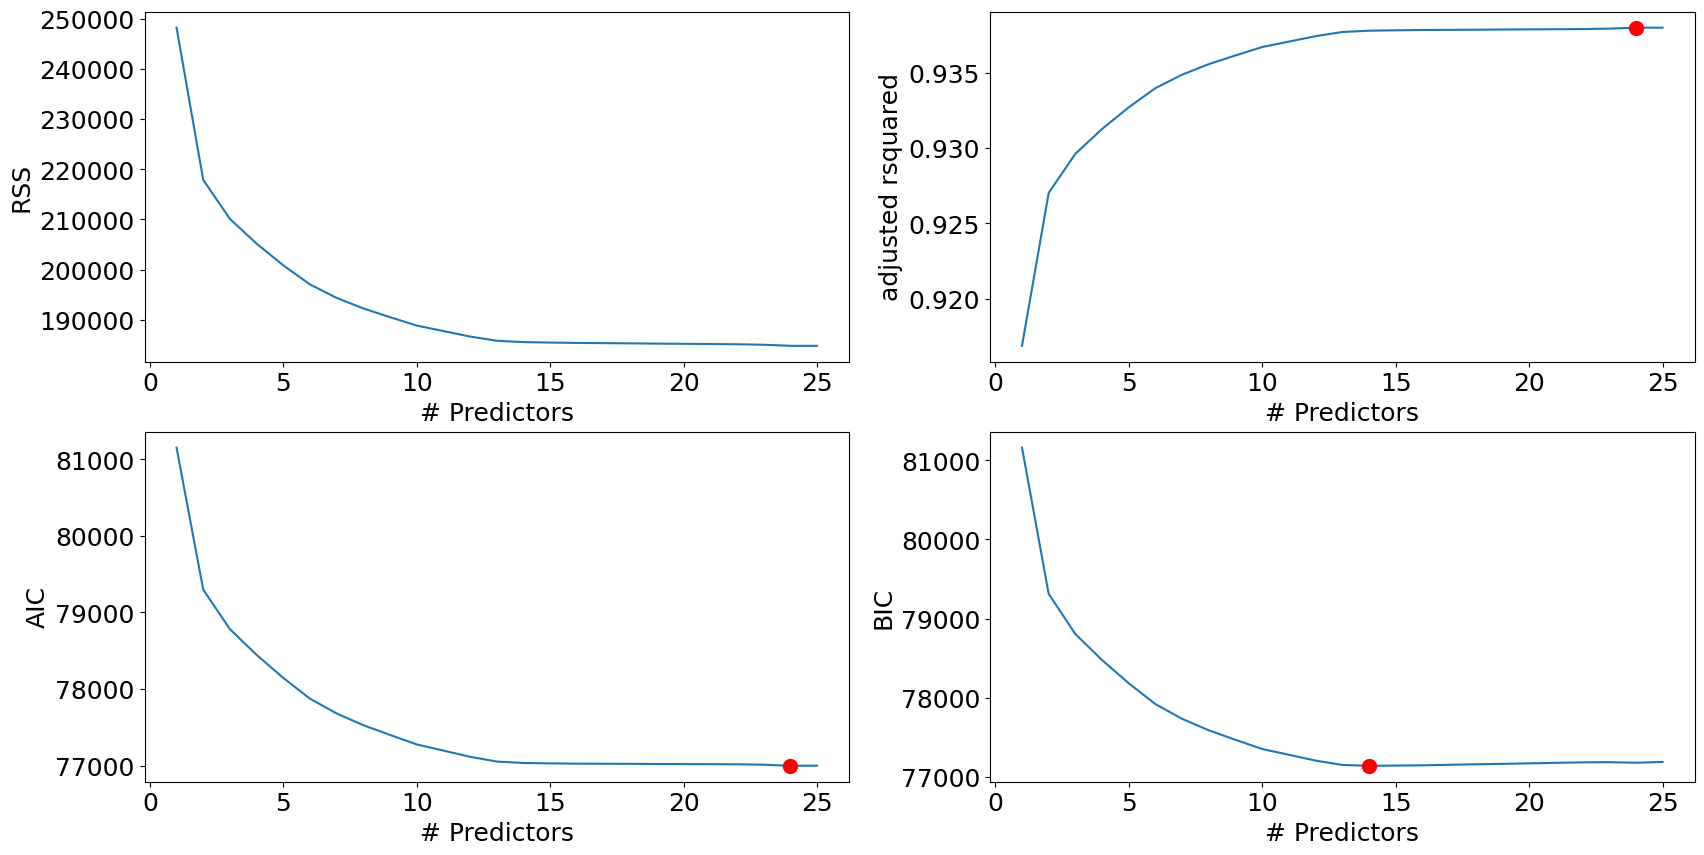

In [9]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_fwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_fwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same fowr AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_fwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_fwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

##### From the graph, we can see that the adjusted R squared does not increase significantly after the best 14-predictor model. As a result, we would follow BIC which gives us a simpler model and use the selected 14 predictors.

In [10]:
print(models_fwd.loc[14, "model"].summary())
# print(models_fwd.loc[14, "model"].params)

                                 OLS Regression Results                                
Dep. Variable:              Loan_rate   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                          1.534e+04
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                        0.00
Time:                        10:37:34   Log-Likelihood:                         -38503.
No. Observations:               14248   AIC:                                  7.703e+04
Df Residuals:                   14234   BIC:                                  7.714e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

### Backward Selection

In [11]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [12]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  25 models on 24 predictors in 1.7929646968841553 seconds.
Processed  24 models on 23 predictors in 1.5611138343811035 seconds.
Processed  23 models on 22 predictors in 1.493682622909546 seconds.
Processed  22 models on 21 predictors in 1.133077621459961 seconds.
Processed  21 models on 20 predictors in 1.2073900699615479 seconds.
Processed  20 models on 19 predictors in 1.0048778057098389 seconds.
Processed  19 models on 18 predictors in 0.9948463439941406 seconds.
Processed  18 models on 17 predictors in 0.9039950370788574 seconds.
Processed  17 models on 16 predictors in 0.7404487133026123 seconds.
Processed  16 models on 15 predictors in 0.5660758018493652 seconds.
Processed  15 models on 14 predictors in 0.5777029991149902 seconds.
Processed  14 models on 13 predictors in 0.562004566192627 seconds.
Processed  13 models on 12 predictors in 0.4349405765533447 seconds.
Processed  12 models on 11 predictors in 0.33362770080566406 seconds.
Processed  11 models on 10 predictor

Text(0, 0.5, 'BIC')

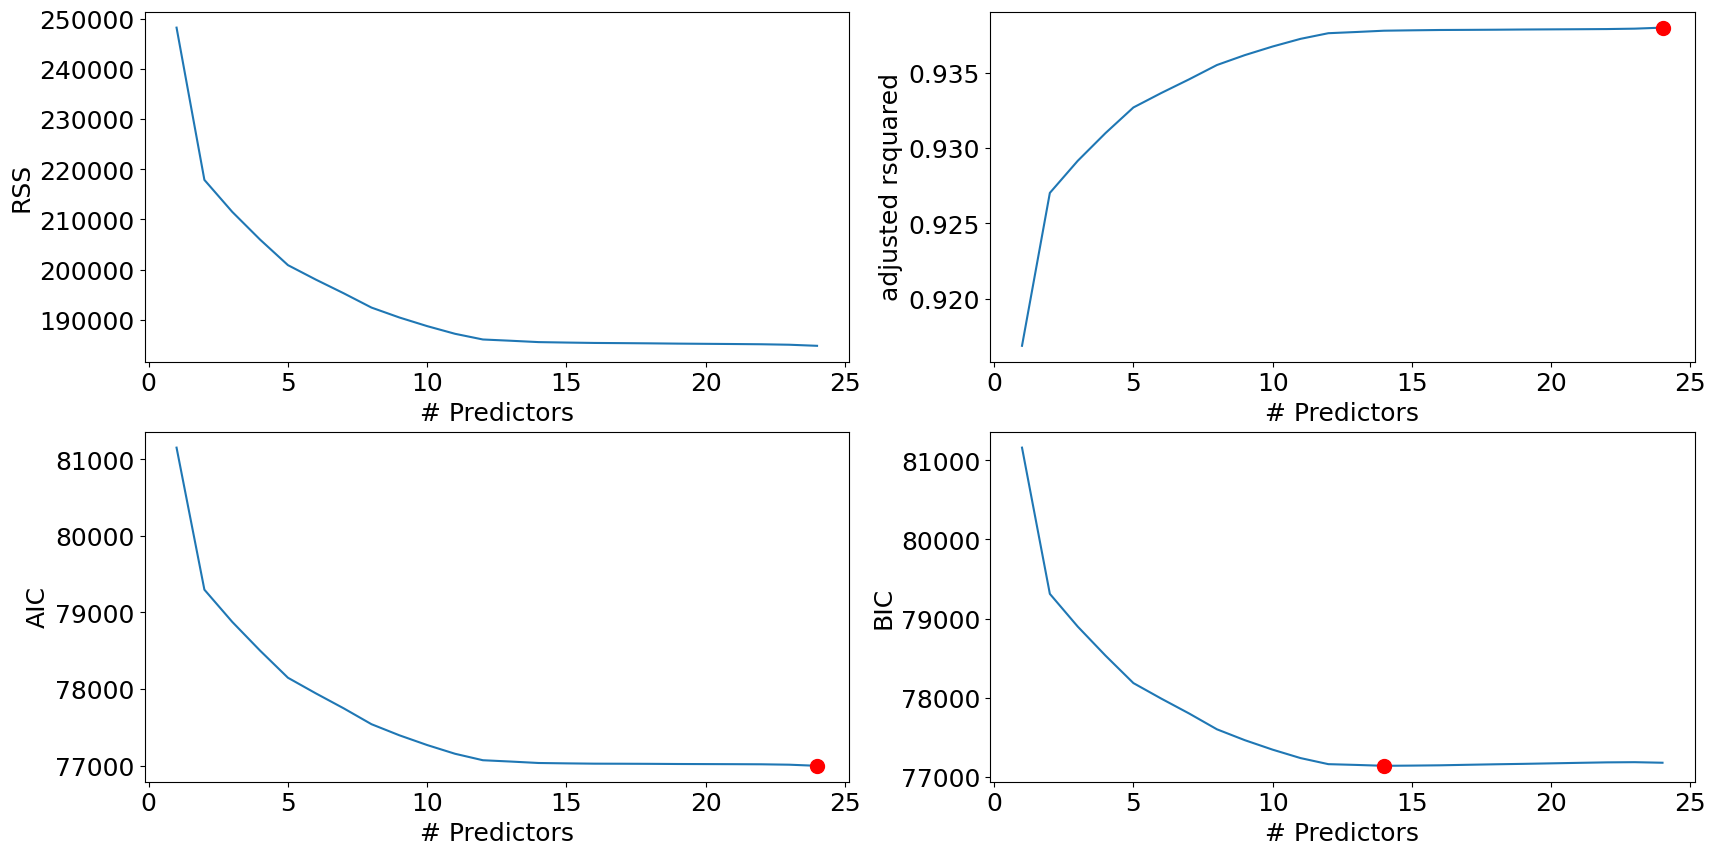

In [13]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_bwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_bwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_bwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_bwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

##### Similar to forward selection, adjusted R squared does not increase significantly after the best 14-predictor model. Therefore, we would follow BIC and adopt the 14 predictor model to avoid overfitting.

In [14]:
print(models_bwd.loc[14, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:              Loan_rate   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                          1.534e+04
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                        0.00
Time:                        10:37:49   Log-Likelihood:                         -38503.
No. Observations:               14248   AIC:                                  7.703e+04
Df Residuals:                   14234   BIC:                                  7.714e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

##### Both forward and backward selections indicate that the optimal number of predictors is 14. However, both selection methods selected the same variables with the same BIC scores.

In [15]:
print(models_fwd.loc[14, "model"].params)

X_train_df = pd.DataFrame(X_train, columns=list(X.columns))
selected_predictors = models_fwd.loc[14, "model"].model.exog_names
model = sm.OLS(y_train, sm.add_constant(X_train_df[selected_predictors])).fit()

# Predict on the test set and calculate MSE
y_pred = model.predict(sm.add_constant(X_test[selected_predictors]))
MSE_LinReg = mean_squared_error(y_test, y_pred)
print("Test MSE for Linear Regression After Variable Selection:", MSE_LinReg)

Loan_term                 0.182884
Revol_util                4.655123
FICO                      0.003322
Income_verified           2.204482
Income_thou              -0.003719
Derogatory_recs           0.881015
delinq_2yrs               0.467371
Home_RENT                 0.585355
Debt_income               0.048096
Credit_history_length    -0.044375
Income_source_verified    0.820349
Revol_balance            -0.000013
Loan_amt                 -0.000039
open_acc                  0.029470
dtype: float64
Test MSE for Linear Regression After Variable Selection: 10.680006315108054


### PCR

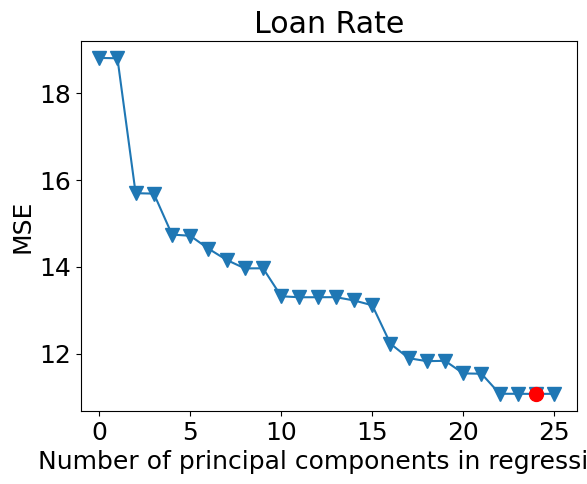

In [16]:
# define PCA and scaler
pca2 = PCA()
scaler = StandardScaler(with_mean=True, with_std=True)

# Scale the data
scaler.fit(X_train)
X_reduced_train = pca2.fit_transform(scaler.transform(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.values.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 25 principle components, adding one component at the time.
for i in np.arange(1, 26):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.values.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.plot(np.array(mse).argmin(),np.array(mse).min(), "or")
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Loan Rate')
plt.xlim(xmin=-1);

In [17]:
#transform the testing data
scaler2 = StandardScaler(with_mean=True, with_std=True)
scaler2.fit(X_test)

X_reduced_test = pca2.transform(scaler2.transform(X_test))

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train, y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

10.69176181204259

Lowest MSE: M=24, the test MSE is 10.69176181204259.

### PLS

(-1.0, 26.2)

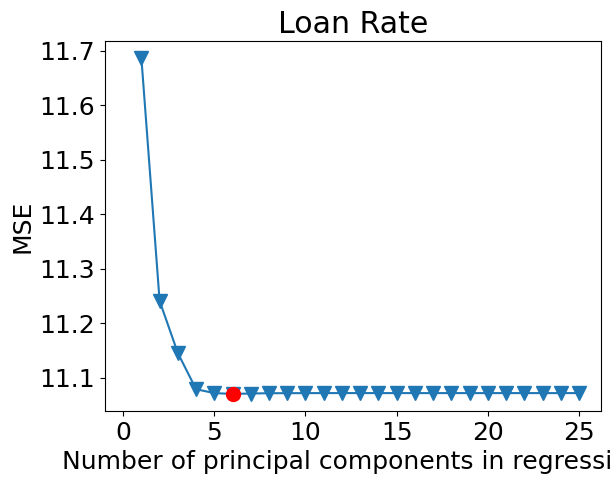

In [18]:
# 10-fold CV, with shuffle
n = len(X_train)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 26):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, X_train, y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 26), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.plot(np.array(mse).argmin()+1,np.array(mse).min(), "or")
plt.title('Loan Rate')
plt.xlim(xmin=-1)

In [19]:
# fit the model and calculate test MSE
pls = PLSRegression(n_components=6)
pls.fit(X_train, y_train)

mean_squared_error(y_test, pls.predict(X_test))

10.693106578498861

Lowest MSE: M=6, the test MSE is 10.693106578498861.